In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # to plot the time series plot
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import os

from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 

In [345]:
# function to read specific csv files from the output folder and merge them
def merge_owid_worldbank_data(country):
    
    country = country.lower() # just in case, lol
    
    df_owid = pd.read_csv(f'output/owid_{country}_impute.csv')
    df_worldbank = pd.read_csv(f'output/worldbank_{country}_impute.csv')
    
    df_country = df_owid.merge(df_worldbank, how='left', on='year')
    df_country.drop(['iso_code_x', 'country_x'], axis=1, inplace=True)
    df_country.rename(columns={'iso_code_y': 'iso_code',
                               'country_y': 'country'}, inplace=True)
    
    # save merged dfs
    df_country.to_csv(f'output/merged_{country}.csv', index=False)
    
    return df_country

##### Import Dataset

In [346]:
df_sector = pd.read_csv('dataset\owid\ghg-emissions-by-sector.csv') # Additional Sector Dataset
df_imputed = pd.read_csv('output\dataset_worldbank_imputed.csv') # Main Dataset
df_china =  merge_owid_worldbank_data('china')
df_us =  merge_owid_worldbank_data('us')
df_india = merge_owid_worldbank_data('india')

In [347]:
df_sector.columns

Index(['Entity', 'Code', 'Year', 'Agriculture (GHG Emissions, CAIT)',
       'Land-Use Change and Forestry (GHG Emissions, CAIT)',
       'Waste (GHG Emissions, CAIT)', 'Industry (GHG Emissions, CAIT)',
       'Manufacturing/Construction energy (GHG Emissions, CAIT)',
       'Transport (GHG Emissions, CAIT)',
       'Electricity & Heat (GHG Emissions, CAIT)',
       'Buildings (GHG Emissions, CAIT)',
       'Fugitive from energy production (GHG Emissions, CAIT)',
       'Other Fuel Combustion (GHG Emissions, CAIT)',
       'Bunker Fuels (GHG Emissions, CAIT)'],
      dtype='object')

In [348]:
df_sector[['Transport ']].divide(1.102, axis="index")

KeyError: "None of [Index(['Transport '], dtype='object')] are in the [columns]"

In [349]:
df_sector[['Transport ']].tail()

KeyError: "None of [Index(['Transport '], dtype='object')] are in the [columns]"

AttributeError: 'AxesSubplot' object has no attribute 'line'

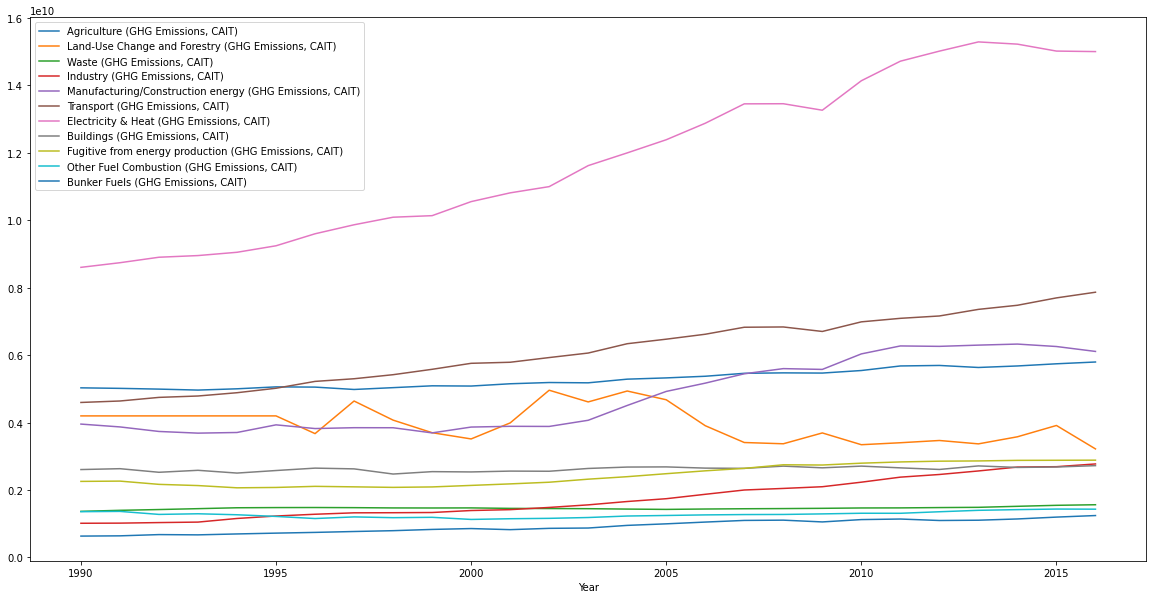

In [354]:
# plt.figure(figsize=(20,10))
df_sector[df_sector.Entity == "World"].set_index('Year').plot(figsize=(20,10)).line()

In [ ]:
df_imputed_china = df_imputed[df_imputed['Country Name'] == "China"]
df_imputed_china[30:-4].shape

In [ ]:
df_sector.columns = df_sector.columns.str.replace("(GHG Emissions, CAIT)", "")
df_sector.columns = df_sector.columns.str.replace(r"\(.*\)","")
df_sector.columns

In [ ]:
df_sector_china = df_sector[df_sector['Code'] == "CHN"]
df_sector_india = df_sector[df_sector['Code'] == "IND"]
df_sector_usa = df_sector[df_sector['Code'] == "USA"]

In [ ]:
df_sector_china.shape
df_sector_china.iloc[:,2:].plot.line()

In [ ]:
df_sector_merged_china = df_imputed_china.merge(df_sector_china, left_on=['Year'], right_on=['Year'],suffixes=('', '_y'))
df_sector_merged_china.columns = df_sector_merged_china.columns.str.rstrip()
df_sector_merged_china.columns

In [ ]:
##### Move the Electricity & Heat to last order
temp_list = df_sector_merged_china.columns.tolist()
temp_list.remove('Electricity & Heat')
temp_list.append('Electricity & Heat')
df_sector_merged_china = df_sector_merged_china[temp_list]
df_sector_merged_china

In [ ]:
df_sector_merged_china.to_csv('output/sector_merge_china.csv', index=False)

##### USA

In [ ]:
df_sector_usa.iloc[:,:].plot.line()

In [ ]:
df_sector_usa.to_csv('output/sector_merge_usa.csv', index=False)

In [ ]:
df_sector_india.to_csv('output/sector_merge_india.csv', index=False)

##### machinelearningmastery

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

values = df_sector_merged_china.drop(['Country Name', 'Code', 'Entity','Year'], axis=1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
# reframed = series_to_supervised(scaled, 1, 1)
reframed = pd.DataFrame(scaled, index=values.index, columns=values.columns)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values
n_train_years = 20
train = values[:n_train_years, :]
test = values[n_train_years:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
reshaped_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_pred = np.concatenate((reshaped_test_X,yhat), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_yhat = inv_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_test = concatenate((test_y, reshaped_test_X), axis=1)
inv_test = scaler.inverse_transform(inv_test)
inv_y = inv_test[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
yhat = model.predict(test_X)
reshaped_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_pred = np.concatenate((reshaped_test_X,yhat), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred

In [ ]:
pd.DataFrame(inv_pred)

In [ ]:
pd.DataFrame(scaler.inverse_transform(reframed)).tail(6)

In [ ]:
reshaped_test_X.shape

In [ ]:
inv_yhat

In [ ]:
inv_test

In [ ]:
scaler.inverse_transform(concatenate((test_y, test_X), axis=1))

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

##### Future 10 Years Prediction

In [ ]:
def predict_future_ten_years():
    years_to_predict = list(range(2017, 2027))
    n_future_years = len(years_to_predict)
    forecast = model.predict(train_X[-n_future_years:])

    forecast_copies = np.repeat(forecast, reframed.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

    forecast_years = []
    for year in years_to_predict:
        forecast_years.append(year)

    df_forecast = pd.DataFrame({"Year":np.array(forecast_years), 'Electricity & Heat':y_pred_future})
    return df_forecast

In [ ]:
df_forecast = predict_future_ten_years()
df_forecast

##### analyticsindiamag

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
for i in df_sector_merged_china.select_dtypes('object').columns:
   le = LabelEncoder().fit(df_sector_merged_china[i])
   df_sector_merged_china[i] = le.transform(df_sector_merged_china[i]) 

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(df_sector_merged_china[df_sector_merged_china.drop(['Country Name', 'Code', 'Entity','Electricity & Heat', 'Year'], axis=1).columns])
Y_data = Y_scaler.fit_transform(df_sector_merged_china[['Electricity & Heat']])

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y) 

In [ ]:
hist_window = 3
horizon = 10
TRAIN_SPLIT = 17
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon) 

In [ ]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0]) 

In [ ]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat() 

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                            input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 


In [ ]:
 model_path = 'Bidirectional_LSTM_Multivariate.h5'
 early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
 checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
 callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(train_data,epochs=150,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

In [ ]:
df_sector_merged_china = df_sector.merge(df_sector_china, left_on=['Code','Year','Entity'], right_on=['Code','Year','Entity'],suffixes=('', '_y'))
df_sector_merged_china.columns = df_sector_merged_china.columns.str.replace("_y", "")
df_sector_merged_china.head()


In [ ]:
df_sector_merged_india = df_sector.merge(df_sector_india, left_on=['Code','Year','Entity'], right_on=['Code','Year','Entity'],suffixes=('', '_y'))
df_sector_merged_india.columns = df_sector_merged_india.columns.str.replace("_y", "")
df_sector_merged_india.head()

In [ ]:
df_sector_merged_usa = df_sector.merge(df_sector_usa, left_on=['Code','Year','Entity'], right_on=['Code','Year','Entity'],suffixes=('', '_y'))
df_sector_merged_usa.columns = df_sector_merged_usa.columns.str.replace("_y", "")
df_sector_merged_usa.head()

In [ ]:
## TO DO
# come up with 2 EDA questions + 1 ML question
# ...


##### VAR MODEL